In [85]:
from mfglib.env import Environment
from mfglib.alg.utils import _ensure_free_tensor,tuple_prod
from mfglib.mean_field import mean_field
from typing import Literal, cast
import torch
from mfglib.alg.greedy_policy_given_mean_field import Greedy_Policy
import matplotlib.pyplot as plt
from mfglib.alg import MFOMO,PriorDescent, FictitiousPlay,OnlineMirrorDescent, TwoScaleLearning
from mfglib.metrics import exploitability_score
from mfglib.alg.q_fn import QFn
import scipy
#import scienceplots
#plt.style.use(['science','no-latex'])
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm

In [119]:
T = 10
s_inv = 5
Q = 3
H = 3
c_value = 0.1
#c_value = 1

c = np.ones(5)
c*= c_value
c = c.tolist()

### Run two scale learning

In [120]:
env_instance = Environment.equilibrium_price(T=T, s_inv=s_inv,Q=Q, H=H, c=c)
solns, solns_mu, expls, diffs, runtimes = TwoScaleLearning(Q_speed = 0.55, mu_speed=1).solve(env_instance, max_iter=5000, verbose=True)
torch.save(solns, "results/production_pi_record.pt")
torch.save(solns_mu, "results/production_nu_record.pt")
torch.save(expls, "results/production_exp_record.pt")
torch.save(diffs, "results/production_diff_record.pt")
torch.save(runtimes, "results/production_time_record.pt")


            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(6,)
	A(4, 4)
	T=10
	r_max=5.6

Algorithm summary:
	OnlineMirrorDescent(Q_speed=0.55, mu_speed=1)
	atol=0.001
	rtol=0.001
	max_iter=5000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 4.38865  |     1.00000     |          0           |  0.000   |
|  1   | 3.81304  |     0.86884     |          1           |  0.008   |
|  2   | 3.30449  |     0.75296     |          2           |  0.018   |
|  3   | 2.90261  |     0.66139     |          3           |  0.025   |
|  4   | 2.58642  |     0.58934     |          4           |  0.034   |
|  5   | 2.33489  |     0.53203     |          5           |  0.041   |
|  6   | 2.13070  |     0.48550     |        

### Run OMD

In [121]:
env_instance = Environment.equilibrium_price(T=T, s_inv=s_inv, Q=Q, H=H, c=c)
solns, expls, runtimes = OnlineMirrorDescent().solve(env_instance, max_iter=5000, verbose=True)
torch.save(solns, "results/production_MFE_pi_record.pt")
torch.save(expls, "results/production_MFE_exp_record.pt")
torch.save(runtimes, "results/production_MFE_time_record.pt")

            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(6,)
	A(4, 4)
	T=10
	r_max=5.6

Algorithm summary:
	OnlineMirrorDescent(alpha=1.0)
	atol=0.001
	rtol=0.001
	max_iter=5000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 4.38865  |     1.00000     |          0           |  0.000   |
|  1   | 3.49470  |     0.79630     |          1           |  0.010   |
|  2   | 2.65540  |     0.60506     |          2           |  0.017   |
|  3   | 2.03367  |     0.46339     |          3           |  0.024   |
|  4   | 1.60191  |     0.36501     |          4           |  0.031   |
|  5   | 1.30216  |     0.29671     |          5           |  0.037   |
|  6   | 1.08907  |     0.24815     |          6           |

### Two scale convergence

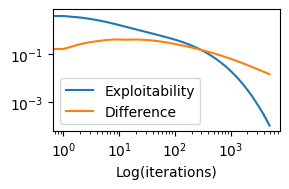

In [139]:
expls = torch.load("results/production_exp_record.pt")
diffs = torch.load("results/production_diff_record.pt")
plt.figure(figsize=(3, 2))
plt.plot(expls, label='Exploitability') 
plt.plot(diffs, label='Difference') 
plt.legend(loc='best')
#plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Log(iterations)')
plt.tight_layout()

plt.savefig('results/production_converge',dpi=300)

plt.show()

### MFE vs CMFE

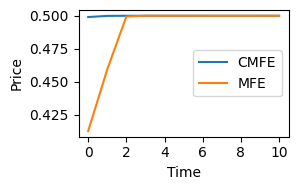

In [132]:
q_tensor = torch.arange(Q + 1).repeat(s_inv + 1, H + 1, 1).permute(0, 2, 1)

## CMFE
env_instance = Environment.equilibrium_price(T=T, s_inv=s_inv, Q=Q, H=H)
solns = torch.load("results/production_pi_record.pt")
IC = torch.load("results/production_nu_record.pt")
pi = solns[-1]
nu = IC[-1]
env_instance.update_initial_distribution(nu)
L = mean_field(env_instance, pi)

plt.figure(figsize=(3, 2))
p_hist = []
for t in range(L.shape[0]):
    p_t = (1.0 / (L[t].mul(q_tensor).sum() + 1.0)) ** (1 / 1.0)
    p_hist.append(p_t)
plt.plot(p_hist, label='CMFE')

## MFE
env_instance = Environment.equilibrium_price(T=T, s_inv=s_inv, Q=Q, H=H)
solns = torch.load("results/production_MFE_pi_record.pt")
pi = solns[-1]
L = mean_field(env_instance, pi)

p_hist = []
for t in range(L.shape[0]):
    p_t = (1.0 / (L[t].mul(q_tensor).sum() + 1.0)) ** (1 / 1.0)
    p_hist.append(p_t)
plt.plot(p_hist, label='MFE')

plt.xticks([0,2,4,6,8,10])
plt.xlabel("Time")
plt.ylabel("Price")
#plt.grid(True)

plt.legend(loc='right')
plt.tight_layout()

plt.savefig('results/production_price',dpi=300)

plt.show()

torch.Size([11, 6, 4, 4])
tensor([[4.9942e-01, 4.9344e-01, 5.7297e-03, 9.4045e-04, 2.5310e-04, 2.1641e-04],
        [4.9899e-01, 5.0051e-01, 2.7637e-04, 2.1640e-04, 1.7702e-12, 9.7463e-22],
        [5.0119e-01, 4.9879e-01, 2.4200e-05, 2.9053e-10, 9.7990e-22, 2.9391e-31],
        [5.0142e-01, 4.9855e-01, 2.4374e-05, 2.9477e-10, 1.4680e-23, 3.6714e-37],
        [5.0140e-01, 4.9858e-01, 2.4421e-05, 2.9586e-10, 1.4729e-23, 3.6865e-37],
        [5.0138e-01, 4.9859e-01, 2.4446e-05, 2.9643e-10, 1.4776e-23, 3.7013e-37],
        [5.0132e-01, 4.9865e-01, 2.4470e-05, 2.9706e-10, 1.4840e-23, 3.7226e-37],
        [5.0123e-01, 4.9875e-01, 2.4511e-05, 2.9803e-10, 1.4943e-23, 3.7587e-37],
        [5.0108e-01, 4.9889e-01, 2.4572e-05, 2.9960e-10, 1.5120e-23, 3.8230e-37],
        [5.0082e-01, 4.9915e-01, 2.4676e-05, 3.0230e-10, 8.2791e-24, 5.6764e-41],
        [5.0027e-01, 4.9971e-01, 1.3319e-05, 2.7940e-14, 1.3172e-27, 1.2404e-40]])


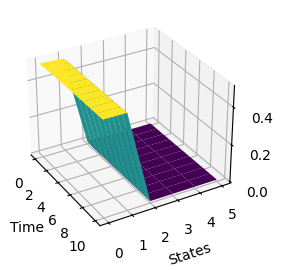

In [159]:
env_instance = Environment.equilibrium_price(T=T, s_inv=s_inv, Q=Q, H=H)
solns = torch.load("results/production_pi_record.pt")
IC = torch.load("results/production_nu_record.pt")
pi = solns[-1]
nu = IC[-1]
env_instance.update_initial_distribution(nu)
L = mean_field(env_instance, pi)
print(L.shape)
mu = L.sum(dim=tuple(range(2, L.ndim)))
print(mu)
mu_np = mu.numpy()

# Create meshgrid for X (days) and Y (states)
days = np.arange(mu.shape[0])  # [0, 1, 2]
states = np.arange(mu.shape[1])  # [0, 1, 2, 3]
X, Y = np.meshgrid(days, states, indexing='ij')  # Use 'ij' to align correctly

# Plotting
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, mu_np, cmap='viridis')

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("States")
ax.set_zlabel("Value")
ax.view_init(elev=30, azim=-30)
ax.set_xticks([0,2,4,6,8,10])
ax.set_yticks([0,1,2,3,4,5])
fig.savefig(
    'results/production_CMFE.png',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1  # a small buffer around the edges
)

plt.show()

torch.Size([11, 6, 4, 4])
tensor([[1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01, 1.6667e-01],
        [1.7177e-01, 4.6526e-01, 1.9352e-01, 1.6936e-01, 8.6827e-05, 4.3040e-11],
        [3.3023e-01, 6.6396e-01, 5.8097e-03, 2.5248e-06, 5.5217e-12, 2.9787e-18],
        [5.0315e-01, 4.9606e-01, 7.8916e-04, 3.0145e-07, 4.4846e-15, 4.9688e-24],
        [5.0457e-01, 4.9464e-01, 7.9699e-04, 3.0786e-07, 5.4143e-16, 4.5457e-25],
        [5.0456e-01, 4.9464e-01, 7.9866e-04, 3.0911e-07, 5.4270e-16, 4.5594e-25],
        [5.0452e-01, 4.9468e-01, 7.9977e-04, 3.0999e-07, 5.4550e-16, 4.5891e-25],
        [5.0443e-01, 4.9477e-01, 8.0130e-04, 3.1123e-07, 5.5002e-16, 4.6389e-25],
        [5.0430e-01, 4.9490e-01, 8.0369e-04, 3.1322e-07, 5.5738e-16, 4.7089e-25],
        [5.0408e-01, 4.9511e-01, 8.0719e-04, 3.1558e-07, 3.0814e-16, 2.5045e-27],
        [5.0362e-01, 4.9594e-01, 4.3825e-04, 1.0245e-09, 1.7397e-18, 5.7134e-27]])


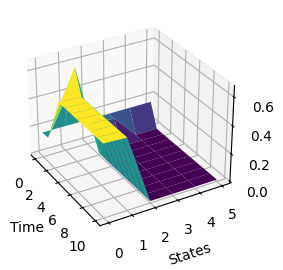

In [153]:
env_instance = Environment.equilibrium_price(T=T, s_inv=s_inv, Q=Q, H=H)
solns = torch.load("results/production_MFE_pi_record.pt")
pi = solns[-1]
L = mean_field(env_instance, pi)
print(L.shape)
mu = L.sum(dim=tuple(range(2, L.ndim)))
print(mu)
mu_np = mu.numpy()

# Create meshgrid for X (days) and Y (states)
days = np.arange(mu.shape[0])  # [0, 1, 2]
states = np.arange(mu.shape[1])  # [0, 1, 2, 3]
X, Y = np.meshgrid(days, states, indexing='ij')  # Use 'ij' to align correctly

# Plotting
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, mu_np, cmap='viridis')

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("States")
ax.set_zlabel("Value")
ax.set_xticks([0,2,4,6,8,10])
ax.set_yticks([0,1,2,3,4,5])

#plt.savefig('results/beach_CMFE',dpi=300)
ax.view_init(elev=30, azim=-30)
#fig.colorbar(surf, shrink=0.5, aspect=10)

fig.savefig(
    'results/production_MFE.png',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1  # a small buffer around the edges
)


plt.show()

### Check contraction

In [111]:
def TV(nu, mu):
    """
    Compute the Total Variation distance between two distributions.
    """
    return torch.sum(torch.abs(nu - mu)) / 2.0

In [166]:
T = 10
s_inv = 5
Q = 3
H = 3
#c_value = 0.1
c_value = 1

c = np.ones(5)
c*= c_value
c = c.tolist()

In [167]:
torch.manual_seed(0)
max_iter = 200
ratio_record = []

for i in tqdm(range(max_iter)):
    nu1 = torch.rand(s_inv+1)
    nu1 = nu1 / nu1.sum()
    env_instance = Environment.equilibrium_price(T=T, s_inv=s_inv, Q=Q, H=H, c=c)
    env_instance.update_initial_distribution(nu1)
    solns, expls, runtimes = OnlineMirrorDescent().solve(env_instance, max_iter=5000, verbose=False)
    pi = solns[-1]
    L = mean_field(env_instance, pi)
    mu = L.sum(dim=tuple(range(2, L.ndim)))
    mu_T1 = mu[-1]

    nu2 = torch.rand(s_inv+1)
    nu2 = nu2 / nu2.sum()
    env_instance = Environment.equilibrium_price(T=T, s_inv=s_inv, Q=Q, H=H, c=c)
    env_instance.update_initial_distribution(nu2)
    solns, expls, runtimes = OnlineMirrorDescent().solve(env_instance, max_iter=5000, verbose=False)
    pi = solns[-1]
    L = mean_field(env_instance, pi)
    mu = L.sum(dim=tuple(range(2, L.ndim)))
    mu_T2 = mu[-1]

    ratio = TV(mu_T1, mu_T2) / TV(nu1, nu2)
    ratio_record.append(ratio.item())


100%|██████████| 200/200 [00:16<00:00, 12.27it/s]


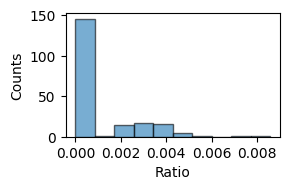

In [168]:
plt.figure(figsize=(3, 2))
plt.hist(ratio_record, bins=10, density=False, alpha=0.6, edgecolor='black')
plt.xlabel('Ratio')
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig(f'results/production_contraction_T{T}_c{c_value}.png',dpi=300)
